# Modelo de Machine Learning

Se implemento el modelo SVD para un sistema de recomendacion con filtro colaborativo

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import joblib
#Libreria para usar pandas parallelismo usando pandas
from dask import dataframe as dd
from dask import delayed
from dask.distributed import Client


from surprise import NormalPredictor, Reader, Dataset, accuracy, SVD
from surprise.model_selection import cross_validate, train_test_split

In [5]:
listacsv = glob.glob('**/[1-8].csv', recursive=True)
df_dask = dd.read_csv(listacsv)
ratings = df_dask.compute()

(Delayed('int-79fcba02-86d6-4a37-8943-a2c392101262'), 4)
<class 'dask.dataframe.core.DataFrame'>
(11024289, 4)
<class 'pandas.core.frame.DataFrame'>


In [6]:
client = Client(processes=False)  

with joblib.parallel_backend('dask'):
    muestra = ratings.sample(frac = 0.01,random_state=0)    

In [7]:
with joblib.parallel_backend('dask'):
    reader = Reader()
    data = Dataset.load_from_df(muestra[['userId', 'movieId', 'rating']], reader)

In [12]:

#kf = KFold(n_splits=5, shuffle=True, random_state=0)
'''
def model_framework(train_data):
    #store the rmse values for each fold in the k-fold loop 
    with joblib.parallel_backend('dask'):
        normp_rmse, svd_rmse, knn_rmse, co_rmse, slope_rmse = [],[],[], [],[]

        for trainset, testset in kf.split(train_data):
            
            #baseline
            normp = NormalPredictor()
            normp.fit(trainset)
            normp_pred = normp.test(testset)
            normp_rmse.append(accuracy.rmse(normp_pred,verbose=False))
            
            #svd
            svd = SVD(n_factors=30, n_epochs=50,biased=True, lr_all=0.005, reg_all=0.4, verbose=False)
            svd.fit(trainset)
            svd_pred = svd.test(testset)
            svd_rmse.append(accuracy.rmse(svd_pred,verbose=False))
            
            #knn
            knn = KNNBasic(k=40,sim_options={'name': 'cosine', 'user_based': False}, verbose=False) 
            knn.fit(trainset)
            knn_pred = knn.test(testset)
            knn_rmse.append(accuracy.rmse(knn_pred,verbose=False))
        
            #co_clustering
            co = CoClustering(n_cltr_u=3,n_cltr_i=3,n_epochs=20)         
            co.fit(trainset)
            co_pred = co.test(testset)
            co_rmse.append(accuracy.rmse(co_pred,verbose=False))

        
        mean_rmses = [np.mean(normp_rmse),
                    np.mean(svd_rmse),
                    np.mean(knn_rmse),
                    np.mean(co_rmse),
                    np.mean(slope_rmse)]
        
        model_names = ['baseline','svd','knn','coclustering','slopeone']
        compare_df = pd.DataFrame(mean_rmses, columns=['RMSE'], index=model_names)
       
    return compare_df
'''    

# Optimizacion

In [14]:
rmse_test_means = []
factores = [1,2,4,8,16,32,64]
model = SVD()

with joblib.parallel_backend('dask'):
        
    for factor in factores:

        print("________________________________________________")
        print("############### ",factor," ######################")
        
        model = SVD(n_factors=factor)
        cv = cross_validate(model, data, measures=['RMSE'], cv = 3, verbose=True)
        rmse_test_means.append(np.mean(cv['test_rmse']))

________________________________________________
###############  1  ######################
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9261  0.9153  1.0469  0.9627  0.0596  
Fit time          9.38    10.39   11.29   10.35   0.78    
Test time         11.44   11.52   9.93    10.96   0.73    
________________________________________________
###############  2  ######################
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9322  0.8984  1.0445  0.9584  0.0624  
Fit time          7.47    7.95    7.68    7.70    0.20    
Test time         7.20    7.93    7.18    7.44    0.35    
________________________________________________
###############  4  ######################
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9442  0.9536  1.0331  0.97

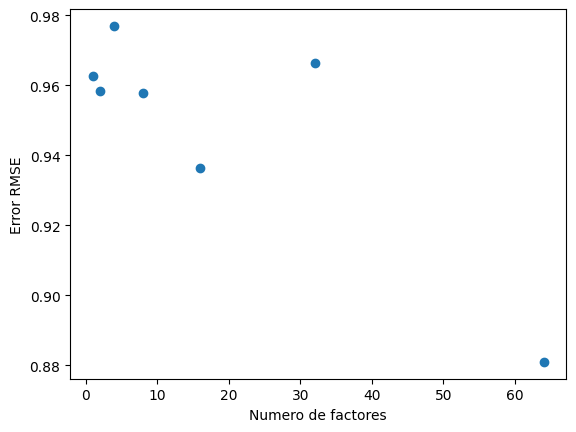

In [15]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [18]:
with joblib.parallel_backend('dask'):
    from surprise.model_selection import GridSearchCV
    param_grid = {'n_factors': [16,32,64],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
                'reg_all': [0.002, 0.02, 0.2]}
    gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
    gs.fit(data)

In [19]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.0407482710248088
{'n_factors': 16, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}


# Modelo Final

In [33]:
params = gs.best_params['rmse']

In [35]:
modelo = SVD(n_factors=params['n_factors'],
             n_epochs=params['n_epochs'],
             lr_all=params['lr_all'],
             reg_all=params['reg_all'])

In [36]:
with joblib.parallel_backend('dask'):
    trainset,testset = train_test_split(data,random_state=0)
    pred = modelo.fit(trainset).test(testset)

In [37]:
accuracy.rmse(pred,verbose=False)

1.0380495122146414

In [38]:
from surprise import dump

In [39]:
dump.dump('modelo_svd',predictions=pred,algo=modelo,verbose=1)

The dump has been saved as file modelo_svd
